# Introduction

Many important technical problems in quantitative fields such as engineering, science or finance are optimization problems. What is usually meant by that is that an abstract problem can be formulated in terms of a quantity, often referred to as a cost function, which then can be either minimized or maximized in a multidimensional space of parameters to arrive at their optimal settings. Such problems can range from the common task of balancing a company budget when constructing a business plan and making decisions about how many employees to hire, all the way up to highly abstract tasks like training artificial neural networks in order to build a model for image recognition.

The Max-Cut problem is one such problem, where the objective is to maximize the cost of partitioning a graph into two subgraphs by removing edges, each edge having a numerical weight assigned to it. In this case the cost is some function of the removed weights, most commonly simply their sum. Although this problem sounds rather abstract, in reality it is of vital importance due to the fact that graph theory easily lends itself to modelling systems consisting of many interacting elements, such as social groups, animal populations, or even business ecosystems and markets. Thus, finding efficient methods of solving the Max-Cut problem can help to understand crucial links in social interactions and help to stimulate useful outcomes or inhibit undesirable influences. In fact, a natural such problem that is very much applicable to our current times is epidemiological modelling. It has long been theorized that a big issue in containing the current pandemic is the existence of superspreaders---individuals who come into many social interactions while not following proper hygienic procedures. One such individual, unaware of their condition, can infect hundreds of people in very short time. Identifying superspreaders and delivering vaccines to them first could be a much more effective way of stopping the spread of the disease than the current blanket measures used throughout the world. In turn, identifying them is a classic case of the Max-Cut problem on a graph of social interaction where the task is to isolate the nodes that have the most (many edges) and the strongest connections (high edge weights) to other nodes.

Formally, the problem can be formulated in the following way. Starting with a graph $G(V,E)$ of $|V|=n$ nodes and edges $E$ characterized by weights $w_{ij}>0, w_{ij}=w_{ji}$, where $(i,j)$ are the nodes connected by the given edge, find a bipartite cut that separates the graph into two disjoint subgraphs, such that the cost function
$$C(\mathbf{x})=\sum_{ij} x_i w_{ij} (1-x_j)$$
takes its maximum value. In the above, the numbers $x=\{0,1\}$ form a solution vector that partitions the graph, i.e., nodes with $x=0$ belong to one subgraph and the ones with $x=1$ belong to the other. Although the statement formulated above is simple enough, it turns out that this is in fact an NP-complete problem, making it exceedingly hard to effectively solve on a classical computer. Thus, the question arises, can it be more efficiently dealt with using a quantum computer.

One reason why this problem seems particularly well suited to quantum computing application is the fact that it naturally maps onto an Ising model, which is exactly the first step that needs to be taken when mapping a problem to a gate based quantum processor. By applying the substitution $x_i=(1-Z_i)/2$, where $Z_i$ is the Pauli $\sigma_z$ operator with eigenvalues $\pm1$, one can derive the Ising representation of the cost function:
$$H=\frac{1}{4}\sum_{ij}w_{ij}(1-Z_i)(1+Z_j)=-\frac{1}{2}\sum_{i<j}w_{ij}Z_i Z_j+\mathrm{offset}.$$
Now the problem is reframed as the minimization (due to the minus appearing in the last form) of the energy given by the above Hamiltonian. We know from quantum mechanics that a Hermitian operator such as this always has a minimal eigenvalue---finding it is often the main concern of many physical theories. One of the more common methods of arriving at a solution is a variational approach, where we start from an ansatz for a solution and minimize the energy with respect to free parameters in that ansatz. It is known that in general this method can always find an upper bound on the ground state energy---it can never produce an energy that is lower than the actual ground state. The variational method is also the standard way of dealing with solving such problems on a quantum computer. It is worth noting however that due to the classical nature of combinatorial optimization problems, an exponential speedup from using a quantum computer is not guaranteed. There have been some promising results using some variational quantum algorithms.

The algorithm in question, the Quantum Approximate Optimization Algorithm by Farhi, Goldstone, and Gutman (2014), or QAOA for short, relies on the above facts to solve combinatorial optimization problems such as the Max-Cut. The algorithm utilizes the following procedure:
1. Map the graph into an Ising Hamiltonian
2. Choose the depth of the quantum circuit $m$
3. Build a trial wavefunction $|\psi(\theta)\rangle$, parametrized by the angles $\{\theta\}$. This is built using a quantum circuit made of fully entangling C-Phase gates (CZGate) to introduce entanglement into the state, and single-qubit Y-axis rotations (RYGate) to create single qubit superpositions with the parameters $\{\theta\}$. This choice is motivated by the fact that the resulting wavefunction only has real coefficients without sacrificing entanglement.
4. Evaluate the Hamiltonian to find the energy of the state, which corresponds to the cost of a partition, $C(\theta)=\langle\psi(\theta)|H|\psi(\theta)\rangle$. Note that this state is a linear combination of actual partitions of the graph and thus is not yet directly interpretable for the original Max-Cut problem.
5. Use a classical optimizer to find a new set of parameters $\{\theta\}$. We will use a Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer provided in qiskit, as it is particularly well suited to optimizing problems where the gradient of the function is not known and it is also tolerant of noise, which is an issue in present day NISQ quantum computers.
6. Repeat steps 4 and 5 until the algorithm converges on a stable minimum
7. Use the last set of $\theta$ parameters to calculate the probability distribution of the different graph partitions $|\langle z_i|\psi(\theta)\rangle|^2$. Check the state with the highest probability, corresponding to the most likely answer. 

Ideally, there should be no more than two clear solutions, corresponding to two complementary partitions (i.e., the resulting $x$ vectors should be the same under exchange of 0s and 1s). If there is more answers, it indicates a symmetry in the graph which means there is more than one answer with the same cost. This is unlikely to happen in a random graph, however in a probabilistic solution on a quantum computer, the final state might contain admixtures of less optimal solutions whose energies are close to the ground state.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely

# Preparing a graph and a graph plotting function

First let's generate a random graph with 12 nodes. We do it using the <code>networkx</code> module, initialising a graph and populating it with edges of random weights. We also define a function for graph visualisation, to plot the graphs and the Max-Cut solutions.

In [2]:
n = 12 # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(i,j,np.random.random()) for i in range(n) for j in range(i+1,n)]
G.add_weighted_edges_from(elist)

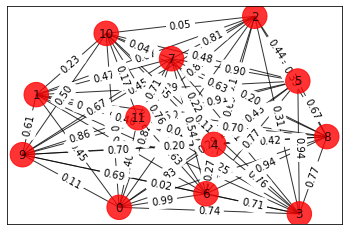

In [3]:
pos = nx.spring_layout(G)

def draw_graph(G, state=None, pos=pos):
    default_axes = plt.axes(frameon=True)
    if state is None:
        colors = ['r' for node in G.nodes()]
    else:
        colors = ['r' if node==True else 'c' for node in state]
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = {key:f"{val:.2f}" for key,val in nx.get_edge_attributes(G, 'weight').items()}
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G)

We can extract the edge data and construct the weight matrix.

In [4]:
w = np.array([[G.get_edge_data(i,j)["weight"] if i!=j else 0 for j in range(n)] for i in range(n)])
print(w)

[[0.         0.45448817 0.26604776 0.73524891 0.83398709 0.28595562
  0.99061489 0.82118275 0.33565954 0.11079726 0.69920364 0.40496774]
 [0.45448817 0.         0.06725923 0.61630104 0.4568934  0.39001266
  0.105542   0.46898683 0.3594836  0.61459365 0.22679231 0.48004845]
 [0.26604776 0.06725923 0.         0.30663541 0.1825933  0.43580035
  0.62699681 0.80839697 0.39289246 0.44797619 0.0541954  0.89189135]
 [0.73524891 0.61630104 0.30663541 0.         0.75525683 0.93703855
  0.70940011 0.16211153 0.76896236 0.02181848 0.11049486 0.25332225]
 [0.83398709 0.4568934  0.1825933  0.75525683 0.         0.43484738
  0.27214932 0.22288042 0.41949081 0.70430059 0.65087506 0.01961357]
 [0.28595562 0.39001266 0.43580035 0.93703855 0.43484738 0.
  0.76911022 0.90292717 0.6680943  0.15515632 0.48179062 0.9145543 ]
 [0.99061489 0.105542   0.62699681 0.70940011 0.27214932 0.76911022
  0.         0.54241462 0.93927915 0.68754037 0.75657659 0.62670045]
 [0.82118275 0.46898683 0.80839697 0.16211153 0.2

# Brute force approach

Let's try a brute force approach as a benchmark for the QAOA solution. We will simply run over all possible partitions of the graph and compute the cost function. However, since complementary partitions correspond to the same solution, we can reduce the number of checks by a factor of two. Therefore, we will have to check 2**(n-1) cases, or 2048 for n=12. This is not too complex for a graph this size, but becomes quickly intractable for bigger problems due to exponential growth of the solution space.

In [43]:
#Define the cost function
def cost(weights,sol):
    s = np.array(sol)
    return s @ weights @ (1-s.T)

Solution: [1 1 1 0 0 1 0 0 1 1 0 0]
Cost: 21.25


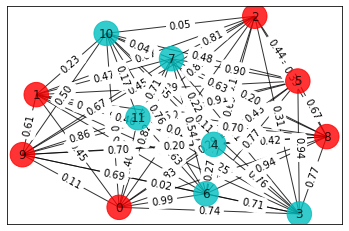

In [6]:
#Construct a bool array representing all the partitions that will be checked
states = np.array([[int(i) for i in bin(b)[2:]] for b in range(2**n-1,2**(n-1)-1,-1)])
#Compute the cost function for all the states
costs = np.array([cost(w,st) for st in states])
#Find the index of the maximum cost solution
idx = np.argmax(costs)
#Plot the solution graph
print("Solution: "+str(states[idx]))
print("Cost: {c:.2f}".format(c=costs[idx]))
draw_graph(G,states[idx])

# Mapping to an Ising Hamiltonian and sanity check

We can run this problem on a quantum computer (simulator), using the <code>qiskit</code> module. For that we need to map the graph weight matrix into an Ising Hamiltonian. Fortunately, <code>qiskit</code> provides builtin functionality to do that.

In [7]:
# Map to an Ising Hamiltonian and print the Pauli String representation
qubitOp, offset = max_cut.get_operator(w)
print('Offset: {of:.2f}'.format(of=offset))
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -16.22
Ising Hamiltonian:
IIIIIIIIIIZZ	(0.22724408466842233+0j)
IIIIIIIIIZIZ	(0.13302387984725517+0j)
IIIIIIIIIZZI	(0.03362961607006831+0j)
IIIIIIIIZIIZ	(0.36762445555825884+0j)
IIIIIIIIZIZI	(0.3081505186280012+0j)
IIIIIIIIZZII	(0.15331770441236853+0j)
IIIIIIIZIIIZ	(0.41699354463627714+0j)
IIIIIIIZIIZI	(0.22844669853859095+0j)
IIIIIIIZIZII	(0.09129664827165129+0j)
IIIIIIIZZIII	(0.37762841489113713+0j)
IIIIIIZIIIIZ	(0.1429778102281014+0j)
IIIIIIZIIIZI	(0.19500632937133439+0j)
IIIIIIZIIZII	(0.2179001774310833+0j)
IIIIIIZIZIII	(0.46851927686472616+0j)
IIIIIIZZIIII	(0.21742369026470443+0j)
IIIIIZIIIIIZ	(0.4953074434982217+0j)
IIIIIZIIIIZI	(0.05277100027846027+0j)
IIIIIZIIIZII	(0.313498404037475+0j)
IIIIIZIIZIII	(0.35470005617422556+0j)
IIIIIZIZIIII	(0.1360746605180877+0j)
IIIIIZZIIIII	(0.3845551083364679+0j)
IIIIZIIIIIIZ	(0.41059137362652687+0j)
IIIIZIIIIIZI	(0.23449341535587992+0j)
IIIIZIIIIZII	(0.40419848560449445+0j)
IIIIZIIIZIII	(0.08105576257091701+0j)
IIIIZIIZIIII	(0.11144021

We can now find the lowest eigenvalue of the Hamiltonian and verify that it matches the brute force approach tried before. As we can see below, we actually get the complementary solution, with the vertices reversed, but the cut cost is the same as before.

energy: -5.03
Ising cost: -21.25
solution: [0 0 0 1 1 0 1 1 0 0 1 1]
Max-Cut cost: 21.25


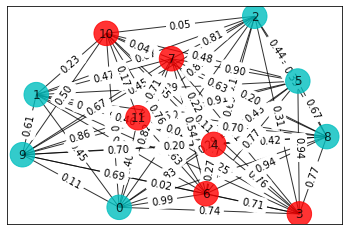

In [8]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
eigens = NumPyMinimumEigensolver(qubitOp)
result = eigens.run()

x = sample_most_likely(result.eigenstate)
print('energy: {r:.2f}'.format(r=result.eigenvalue.real))
print('Ising cost: {r:.2f}'.format(r=result.eigenvalue.real + offset))
print('solution:', s:=max_cut.get_graph_solution(x))
print('Max-Cut cost: {r:.2f}'.format(r=max_cut.max_cut_value(x, w)))

draw_graph(G, s)

# QAOA implementation on a quantum simulator

Now we are in a good position to run the problem on a quantum simulator. We will use the <code>statevector_simulator</code> backend and the <code>SPSA</code> optimizer. The initial ansatz for the quantum state will be generated using a <code>TwoLocal</code> function. We will use a preset circuit depth of 5, but in a more sophisticated approach this could be changed adaptively during the procedure. The ansatz consists of consecutive applications of single qubit Y-axis rotations and a Z entangler for adjacent qubits.

In [39]:
aqua_globals.random_seed = np.random.default_rng(371) #Set the random number generator
backend = Aer.get_backend('statevector_simulator') #Choose backend

In [40]:
#Initialise the qunatum instance
seed = 32674
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
#Construct and plot the ansatz
ansatz = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear', insert_barriers=True) #Prepare the ansatz
#print(ansatz)

Now we run the procedure on the above ansatz and, after convergence, check the cost value, runtime, and plot the partition graph

energy: -4.78
time: 238.90 s
Ising cost:  -20.99
solution: [1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.]
Max-Cut cost: 21.25


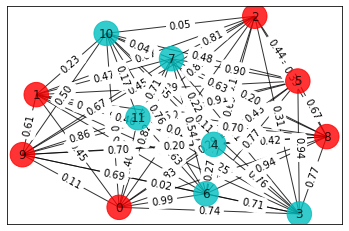

In [41]:
# Construct and run VQE
spsa = SPSA(maxiter=300) #Initialise the classical stochastic optimizer
vqe = VQE(qubitOp, ansatz, spsa, quantum_instance=quantum_instance) #Initilise the eigensolver
result = vqe.run()

# print results
x = sample_most_likely(result.eigenstate)
print('energy: {r:.2f}'.format(r=result.eigenvalue.real))
print('time: {r:.2f} s'.format(r=result.optimizer_time))
print('Ising cost:  {r:.2f}'.format(r=result.eigenvalue.real + offset))
print('solution:', s:=max_cut.get_graph_solution(x))
print('Max-Cut cost: {r:.2f}'.format(r=max_cut.max_cut_value(x, w)))

# plot results
draw_graph(G, s)

We can also check the full construction of the wavefunction to see if the found solution is unique. We do this by plotting the probabilities of different basis states (graph partitions), after applying a cut-off at 0.01 to get rid of noise. As can be seen, there is a clear contender which is the right solution, but there are other proposals with significant probabilities, whose energies are slightly higher than the optimal solution. Interestingly enough, in this particular simulation the complementary solution does not appear in the wavefunction, although in some of the test runs we have seen instances where the two complemetary solutions had comparable probabilities. We suspect this high variation in the result might have something to do with the stochastic nature of the optimizer.

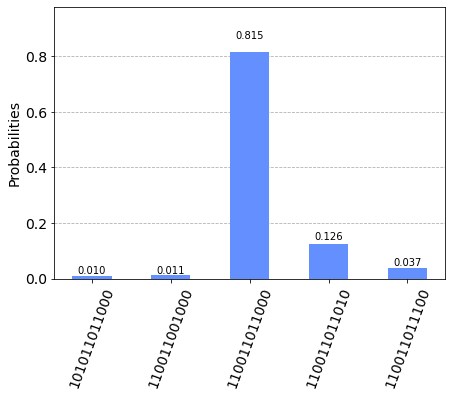

In [42]:
D = {str(bin(i))[2:].zfill(n):c for i,a in enumerate(result.eigenstate) if (c:=abs(a)**2)>1e-2}
plot_histogram(D)

# Optimizing the ansatz for complementary solutions

Finally, we can make use of the complementary solutions to improve the ansatz. This corresponds to breaking the $Z_2$ symmetry of the Ising problem by hand by choosing one of the bits to be 0 from the start and not perfoming any operations on it. This reduces slightly the number of parameters and gives less leeway to the optimizer to get stuck in a local minimum.

In [31]:
seed = 46824
quantum_instance2 = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
entangler_map = [(i,i+1) for i in range(1,n-1)]
ansatz2 = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, 
              entanglement=entangler_map, skip_unentangled_qubits=True, insert_barriers=True) #Prepare the ansatz
#print(ansatz2)

energy: -4.94
time: 222.66 s
Ising cost:  -21.15
solution: [1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.]
Max-Cut cost: 21.25


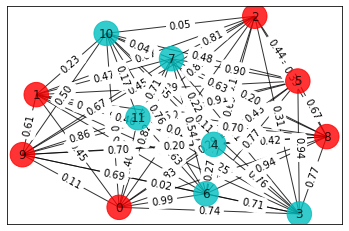

In [32]:
# Prepare and run VQE
spsa = SPSA(maxiter=300) #Initialise the classical stochastic optimizer
vqe = VQE(qubitOp, ansatz2, spsa, quantum_instance=quantum_instance2) #Initilise the eigensolver
result = vqe.run()

# print results
x = sample_most_likely(result.eigenstate)
print('energy: {r:.2f}'.format(r=result.eigenvalue.real))
print('time: {r:.2f} s'.format(r=result.optimizer_time))
print('Ising cost:  {r:.2f}'.format(r=result.eigenvalue.real + offset))
print('solution:', s:=max_cut.get_graph_solution(x))
print('Max-Cut cost: {r:.2f}'.format(r=max_cut.max_cut_value(x, w)))

# plot results
draw_graph(G, s)

As we can see, the runtime is reduced only very slightly, however if we plot the wavefunction, we can see that the probability of the correct solution is now practically 1, making it much more unambiguous.

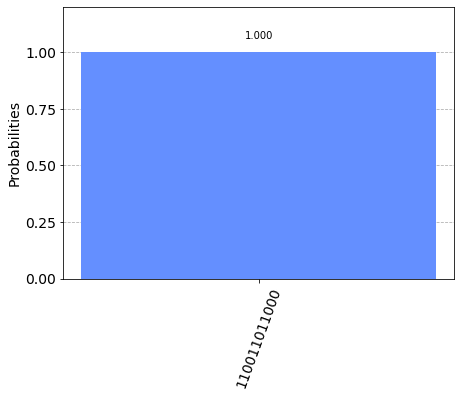

In [33]:
D = {str(bin(i))[2:].zfill(n):c for i,a in enumerate(result.eigenstate) if (c:=abs(a)**2)>1e-2}
plot_histogram(D)